In [1]:
import tensorflow as tf

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
print("TPU initialized")

tf.tpu.experimental.initialize_tpu_system(tpu)
print("TPU system initialized")

tpu_strategy = tf.distribute.TPUStrategy(tpu)
print("TPU strategy initialized")

E0000 00:00:1728583947.559091   60862 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1010 18:12:27.567974633   60862 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1010 18:12:27.567991825   60862 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1010 18:12:27.567995606   60862 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1010 18:12:27.567998609   60862 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1010 18:12:27.568001510   60862 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

TPU initialized
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728583953.046557   60862 service.cc:145] XLA service 0x568fd82d9040 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728583953.046619   60862 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728583953.046623   60862 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728583953.046626   60862 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728583953.046629   60862 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728583953.046631   60862 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728583953.046633   60862 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728583953.046636   60862 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728583953.046638   60862 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
TPU system initialized
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/dev

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [3]:
Imagenes = np.load('/kaggle/input/Imagenes Lentes/ImagenesTotales.npy')

In [4]:
Labels = np.load('/kaggle/input/Imagenes Lentes/Labels.npy')

In [5]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

images_train, images_test, targets_train, targets_test = model_selection.train_test_split(Imagenes, Labels, test_size = 0.2)

targets_train = to_categorical(targets_train, num_classes = 2)
targets_test = to_categorical(targets_test, num_classes = 2)

images_train = np.expand_dims(images_train, axis = -1)
images_test = np.expand_dims(images_test, axis = -1)

images_train.shape

(4400, 512, 512, 1)

In [6]:
from tensorflow.keras import models, layers

with tpu_strategy.scope():
    input_shape = (512, 512, 1)
    
    model = models.Sequential([
        layers.Input(shape = input_shape),
        layers.Conv2D(64, (5, 5), activation = 'relu', padding = 'valid'),
        layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'valid'),
        layers.MaxPooling2D((4, 4)),
        layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'valid'),
        layers.Conv2D(16, (5, 5), activation = 'relu', padding = 'valid'),
        layers.MaxPooling2D((4, 4)),
        layers.Flatten(),
        layers.Dense(16, activation = 'relu'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(2, activation = 'softmax'),
    ])

    model.summary()

    optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.0001, use_ema = True)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

I0000 00:00:1728583962.536022   60862 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 508, 508, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 506, 506, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 120, 120, 16)   │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       230,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,514 (1.15 MB)

 Trainable params: 300,514 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    images_train, targets_train,
    validation_data = (images_test, targets_test),
    epochs = 25,
    batch_size = 16*tpu_strategy.num_replicas_in_sync,
    verbose = 1
)

Epoch 1/25


2024-10-10 18:13:00.216025: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728583980.793989   61662 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ef49ef8a37c78118:0:0), session_name()


 1/35 ━━━━━━━━━━━━━━━━━━━━ 5:51 10s/step - accuracy: 0.1875 - loss: 16.5692

I0000 00:00:1728583988.127836   61662 tpu_compile_op_common.cc:245] Compilation of ef49ef8a37c78118:0:0 with session name  took 7.333795997s and succeeded
I0000 00:00:1728583988.136248   61662 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ef49ef8a37c78118:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2985413033537703588", property.function_library_fingerprint = 2867463465923589054, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16,512,512,1,;16,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728583988.136294   61662 tpu_compilation_cache_interface.cc:541] After adding entry for key 

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5520 - loss: 4.5142

I0000 00:00:1728583994.518312   61668 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d3796c50e8323f2f:0:0), session_name()


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.5554 - loss: 4.4484

I0000 00:00:1728584003.247315   61668 tpu_compile_op_common.cc:245] Compilation of d3796c50e8323f2f:0:0 with session name  took 8.728949964s and succeeded
I0000 00:00:1728584003.254215   61668 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d3796c50e8323f2f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2985413033537703588", property.function_library_fingerprint = 2867463465923589054, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "6,512,512,1,;6,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728584003.254247   61668 tpu_compilation_cache_interface.cc:541] After adding entry for key d3

35/35 ━━━━━━━━━━━━━━━━━━━━ 43s 959ms/step - accuracy: 0.5587 - loss: 4.3863 - val_accuracy: 0.7971 - val_loss: 0.6319
Epoch 2/25


I0000 00:00:1728584020.775589   61611 tpu_compile_op_common.cc:245] Compilation of d12d01122cfbf1da:0:0 with session name  took 5.985822326s and succeeded
I0000 00:00:1728584020.777967   61611 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d12d01122cfbf1da:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16515975580150887265", property.function_library_fingerprint = 17803516088917135626, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "10,512,512,1,;10,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728584020.777990   61611 tpu_compilation_cache_interface.cc:541] After adding entry for ke

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.7662 - loss: 0.8961 - val_accuracy: 0.8261 - val_loss: 0.5473
Epoch 3/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.8293 - loss: 0.5083 - val_accuracy: 0.8261 - val_loss: 0.5552
Epoch 4/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.8020 - loss: 0.5629 - val_accuracy: 0.8188 - val_loss: 0.5725
Epoch 5/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.8332 - loss: 0.4618 - val_accuracy: 0.8188 - val_loss: 0.5694
Epoch 6/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.8094 - loss: 0.4371 - val_accuracy: 0.8043 - val_loss: 0.5624
Epoch 7/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.7975 - loss: 0.4595 - val_accuracy: 0.8043 - val_loss: 0.5693
Epoch 8/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.8186 - loss: 0.4417 - val_accuracy: 0.8043 - val_loss: 0.5770
Epoch 9/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.8448 - loss: 0.3896 - val_accuracy: 0.8116 - val

In [8]:
test_loss, test_acc = model.evaluate(images_test, targets_test)
print("Test accuracy:", test_acc)

I0000 00:00:1728584248.089213   61625 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e37d9ea61d195cae:0:0), session_name()


 5/35 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7433 - loss: 0.8926

I0000 00:00:1728584253.708303   61625 tpu_compile_op_common.cc:245] Compilation of e37d9ea61d195cae:0:0 with session name  took 5.619038804s and succeeded
I0000 00:00:1728584253.710595   61625 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e37d9ea61d195cae:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16515975580150887265", property.function_library_fingerprint = 17803516088917135626, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,512,1,;4,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728584253.710620   61625 tpu_compilation_cache_interface.cc:541] After adding entry for key 

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7974 - loss: 0.7751

I0000 00:00:1728584254.754716   61594 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(4b9f82a2e5e07a0b:0:0), session_name()


35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.8003 - loss: 0.7674
Test accuracy: 0.8333333134651184


I0000 00:00:1728584260.937393   61594 tpu_compile_op_common.cc:245] Compilation of 4b9f82a2e5e07a0b:0:0 with session name  took 6.182636976s and succeeded
I0000 00:00:1728584260.939328   61594 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(4b9f82a2e5e07a0b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16515975580150887265", property.function_library_fingerprint = 17803516088917135626, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,512,1,;2,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728584260.939356   61594 tpu_compilation_cache_interface.cc:541] After adding entry for key 

In [28]:
with tpu_strategy.scope():
    model.save('/kaggle/working/modelo83%.keras')

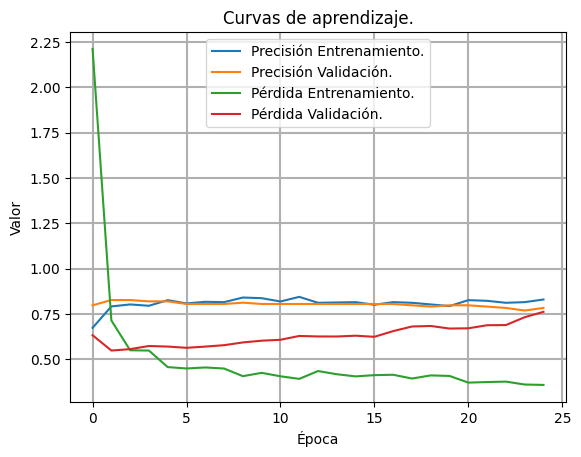

In [35]:
plt.plot(history.history['accuracy'], label = 'Precisión Entrenamiento.')
plt.plot(history.history['val_accuracy'], label = 'Precisión Validación.')
plt.plot(history.history['loss'], label = 'Pérdida Entrenamiento.')
plt.plot(history.history['val_loss'], label = 'Pérdida Validación.')

plt.title('Curvas de aprendizaje.')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.grid(linewidth = 1.5)
plt.legend(loc = 'upper center')

plt.savefig('/kaggle/working/CurvasAprendizaje.jpg', format = 'jpg')
plt.show()

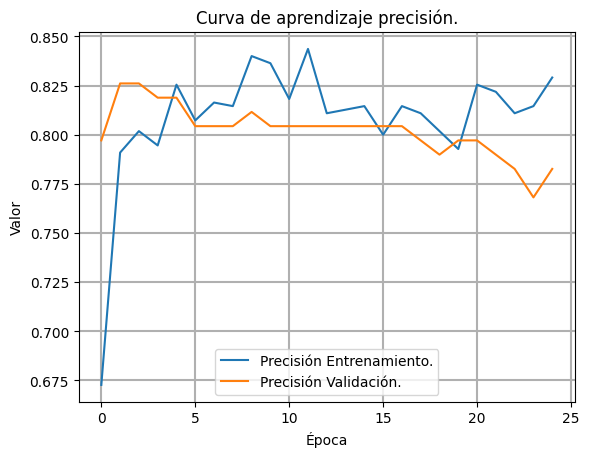

In [37]:
plt.plot(history.history['accuracy'], label = 'Precisión Entrenamiento.')
plt.plot(history.history['val_accuracy'], label = 'Precisión Validación.')

plt.title('Curva de aprendizaje precisión.')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.grid(linewidth = 1.5)
plt.legend(loc = 'lower center')

plt.savefig('/kaggle/working/CurvasAprendizajeAcc.jpg', format = 'jpg')
plt.show()

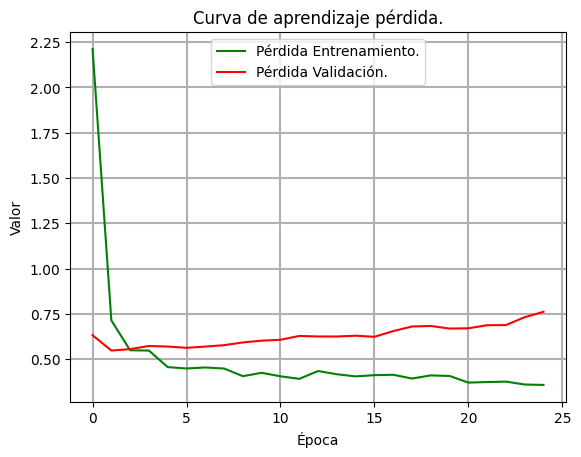

In [44]:
plt.plot(history.history['loss'], label = 'Pérdida Entrenamiento.', color = 'g')
plt.plot(history.history['val_loss'], label = 'Pérdida Validación.', color = 'r')

plt.title('Curva de aprendizaje pérdida.')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.grid(linewidth = 1.5)
plt.legend(loc = 'upper center')

plt.savefig('/kaggle/working/CurvasAprendizajeLoss.jpg', format = 'jpg')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


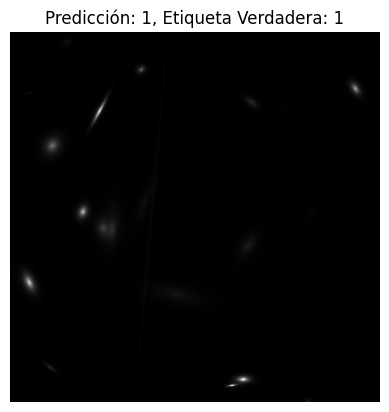

¡Predicción Correcta!
Imagen número 590


In [25]:
import random

def show_random_prediction(model):
    
    idx = random.randint(0, len(images_test) - 1)
    image = images_test[idx]
    true_label = np.argmax(targets_test[idx])
    
    
    pred = model.predict(np.expand_dims(image, axis = 0))
    predicted_label = np.argmax(pred)

    
    plt.imshow(image, cmap = 'gray')
    plt.title(f'Predicción: {predicted_label}, Etiqueta Verdadera: {true_label}')
    plt.axis('off')
    plt.savefig('/kaggle/working/Prediccion_Correcta.jpg', format='jpg')
    plt.show()

    
    if predicted_label == true_label:
        print("¡Predicción Correcta!")
    else:
        print("Predicción Incorrecta.")
        
    print('Imagen número', idx)

    
show_random_prediction(model)

In [30]:
images_train_large, images_test_large, targets_train_large, targets_test_large = model_selection.train_test_split(Imagenes, Labels, test_size = 0.3)

targets_train_large = to_categorical(targets_train_large, num_classes = 2)
targets_test_large = to_categorical(targets_test_large, num_classes = 2)


images_train_large = np.expand_dims(images_train_large, axis = -1)
images_test_large = np.expand_dims(images_test_large, axis = -1)

print("Tamaño del nuevo conjunto de entrenamiento:", images_train_large.shape)
print("Tamaño del nuevo conjunto de prueba:", images_test_large.shape)

Tamaño del nuevo conjunto de entrenamiento: (3850, 512, 512, 1)
Tamaño del nuevo conjunto de prueba: (1650, 512, 512, 1)


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step


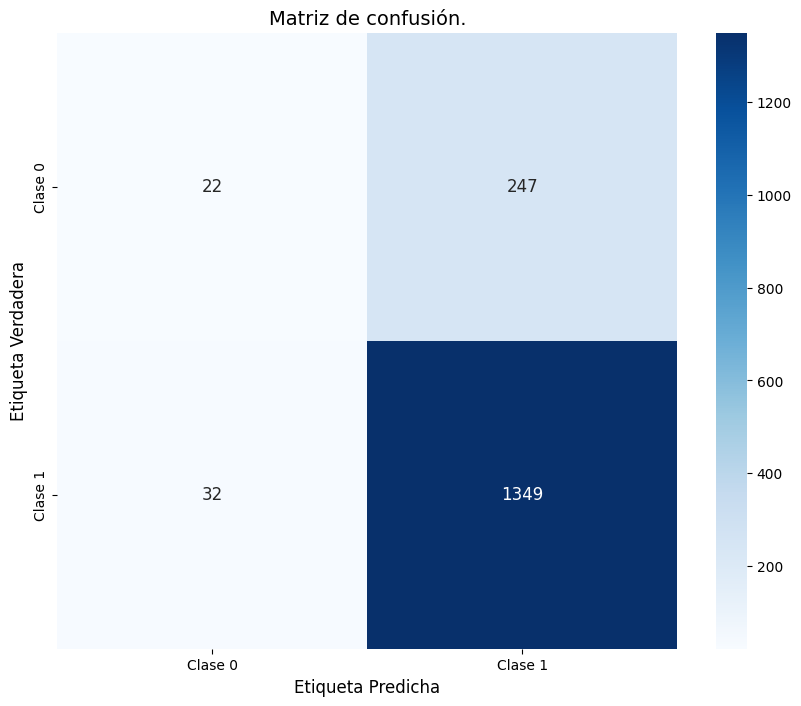

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_pred_large = model.predict(images_test_large)
y_pred_classes_large = np.argmax(y_pred_large, axis = 1)
y_true_large = np.argmax(targets_test_large, axis = 1)


conf_matrix_large = confusion_matrix(y_true_large, y_pred_classes_large)


plt.figure(figsize = (10, 8))
sns.heatmap(conf_matrix_large, annot = True, fmt = "d", cmap = "Blues", xticklabels = ['Clase 0', 'Clase 1'], yticklabels = ['Clase 0', 'Clase 1'], annot_kws={"size": 12})
plt.ylabel('Etiqueta Verdadera', fontsize = 12)
plt.xlabel('Etiqueta Predicha', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Matriz de confusión.', fontsize = 14)

plt.savefig('/kaggle/working/MatrizConfusion.jpg', format = 'jpg')
plt.show()